In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import keras
import tensorflow
import os
import random
import cv2
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from keras import regularizers
from tensorflow.keras.optimizers import Adam,SGD
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.metrics import PrecisionAtRecall,Recall 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [2]:
path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

co = {'COVID': 0,'Lung_Opacity': 1,'Normal': 2, 'Viral Pneumonia': 3}
tit = {'COVID': 'Covid-19','Lung_Opacity': 'Lung Opacity','Normal': 'Healthy','Viral Pneumonia': 'Viral Pneumonia'}

imgid = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}
Data = pd.DataFrame.from_dict(imgid, orient = 'index').reset_index()
Data.columns = ['image_id','path']
classes = Data.image_id.str.split('-').str[0]
Data['dig'] = classes
Data['tar'] = Data['dig'].map(co.get) 
Data['Class'] = Data['dig'].map(tit.get) 

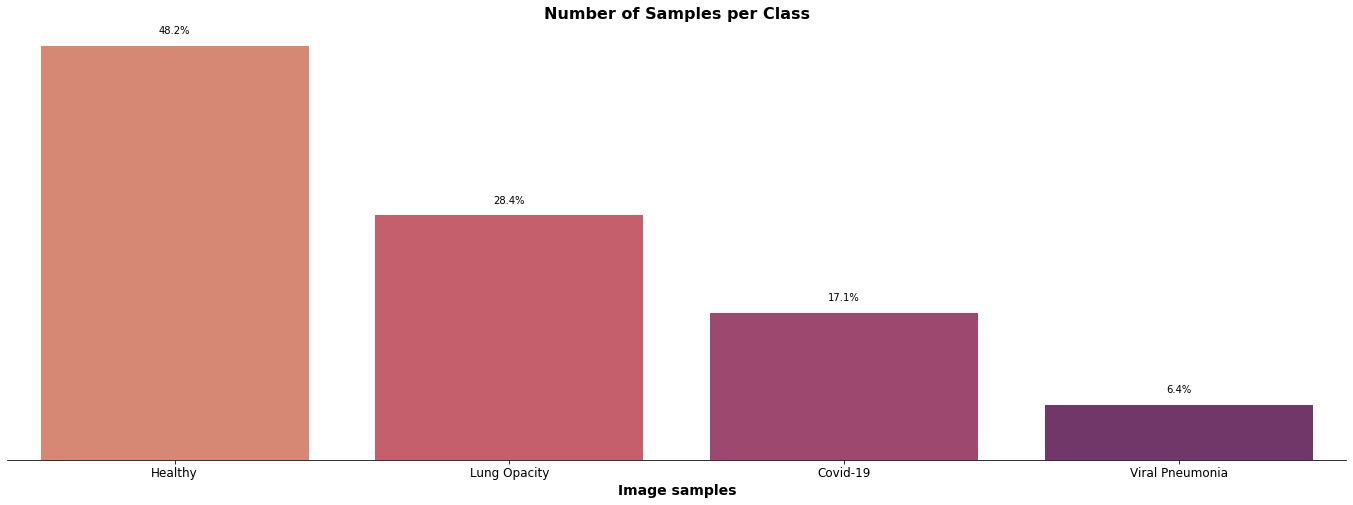

In [3]:
samples,features = Data.shape
plt.figure(figsize=(24,8))
x = sns.countplot(data = Data,x='Class',order = Data['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
x.set_xlabel('Image samples',fontsize = 14,weight = 'bold')
x.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');
for p in x.patches:
    x.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

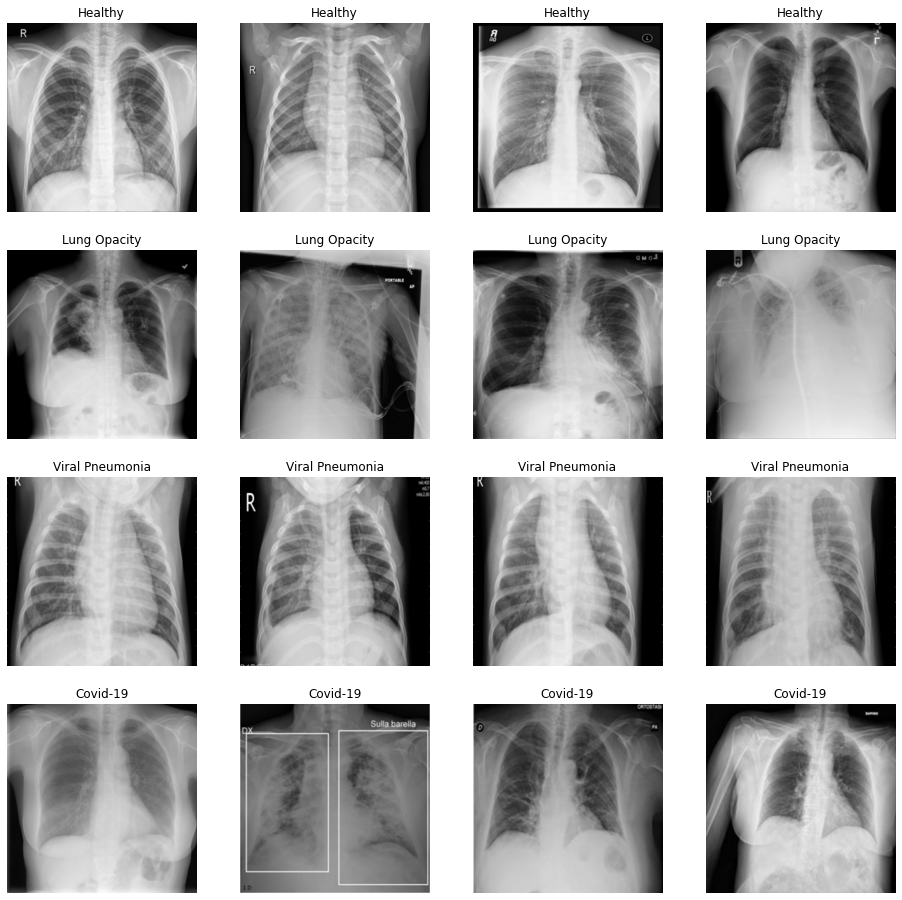

In [4]:
simg = []
classes = Data.Class.unique()
for i in classes:
    for j in range(4):
        simg.append(cv2.imread(Data[Data.Class == i].iloc[j, 1]))
        
# plot each image from sample_imgs
plt.figure(figsize=(16,16))

for i in range(0,16):
    plt.subplot(4, 4, i+1)
    plt.imshow(simg[i])
    plt.axis('off')
    plt.title(classes[i//4])

In [5]:
path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
num_classes = len(classes)
batch_size = 16
train_data = ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_data = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train = train_data.flow_from_directory(directory=path, target_size=(299, 299),class_mode='categorical',subset='training',shuffle=True, classes=classes,batch_size=batch_size, color_mode="grayscale")

test = test_data.flow_from_directory(directory=path, target_size=(299, 299),class_mode='categorical',subset='validation',shuffle=False, classes=classes,batch_size=batch_size, color_mode="grayscale")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(299, 299, 1)))
model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size = (2, 2)))
          
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(256, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size = (2, 2)))
        
model.add(Conv2D(512, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(512, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size = (2, 2)))          

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',Recall()])
model.summary()

2021-11-15 15:03:14.848403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 15:03:14.988265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 15:03:14.989262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 15:03:14.991326: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 149, 149, 64)      36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 74, 74, 128)       7

In [7]:

epochs = 1000
history = model.fit(train, steps_per_epoch=len(train) // batch_size, validation_steps=len(test) // batch_size,  validation_data=test, epochs=epochs,verbose=1)
pred = model.predict(test)

2021-11-15 15:03:18.289022: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2021-11-15 15:03:20.830666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


66/66 [==============================] - 28s 272ms/step - loss: 1.2377 - accuracy: 0.4470 - recall: 0.0786 - val_loss: 2.2590 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
66/66 [==============================] - 17s 254ms/step - loss: 1.2231 - accuracy: 0.4678 - recall: 0.1070 - val_loss: 2.6607 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
66/66 [==============================] - 16s 245ms/step - loss: 1.2322 - accuracy: 0.4706 - recall: 0.0795 - val_loss: 1.6414 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/1000
66/66 [==============================] - 16s 244ms/step - loss: 1.1770 - accuracy: 0.4848 - recall: 0.1345 - val_loss: 1.4723 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/1000
66/66 [==============================] - 16s 249ms/step - loss: 1.1265 - accuracy: 0.5009 - recall: 0.2547 - val_loss: 1.5892 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/1000
66/66 [==============================] - 16s 

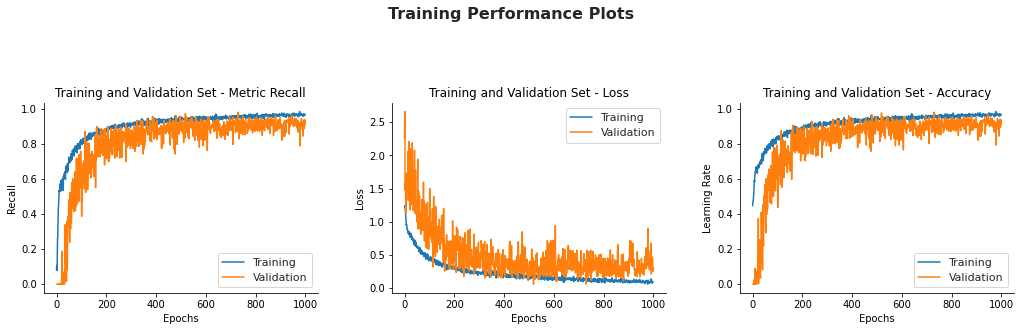

In [8]:
fig, pic = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['recall'],ax=pic[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_recall'],ax=pic[0],label="Validation");
ax.set_ylabel('Recall')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=pic[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=pic[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=pic[2],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=pic[2],label="Validation");
ax.set_ylabel('Learning Rate')    
pic[0].set_title("Training and Validation Set - Metric Recall")
pic[1].set_title("Training and Validation Set - Loss")
pic[2].set_title("Training and Validation Set - Accuracy")

for ax in pic:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

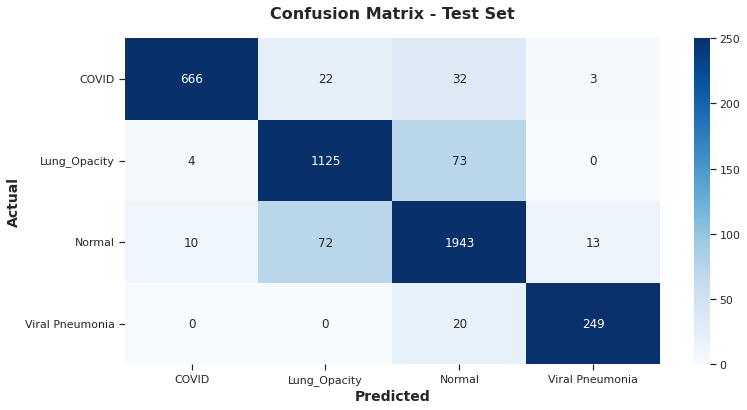

In [9]:
predictions = np.array(list(map(lambda x: np.argmax(x), pred)))
true=test.classes
Matrix = pd.DataFrame(confusion_matrix(true, predictions), columns=classes, index =classes)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(Matrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
keras.backend.clear_session()

**Overall Results**
Accuracy Result: 94.12%
Precision Result: 94.54%
Recall Result: 93.40%
F-Score Result: 93.94%


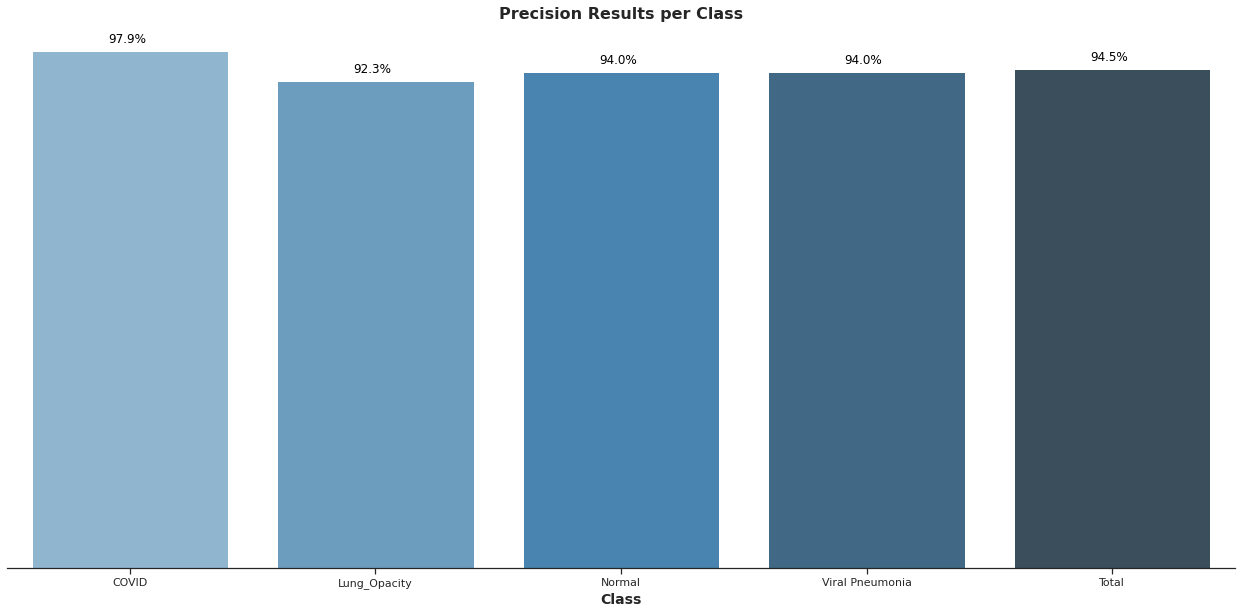

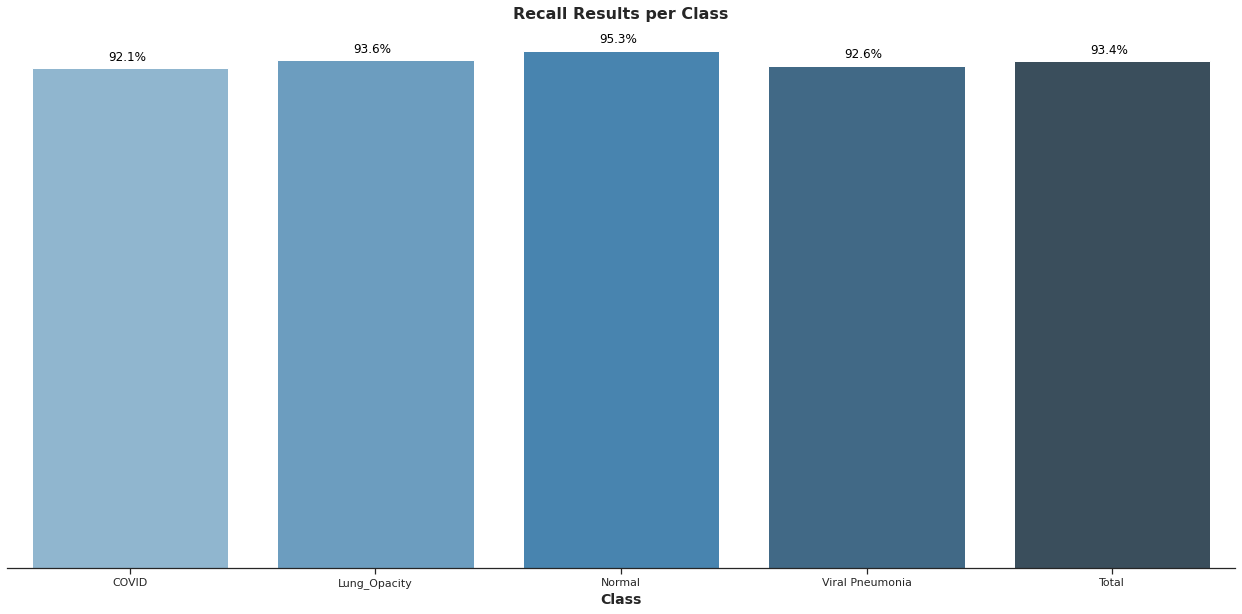

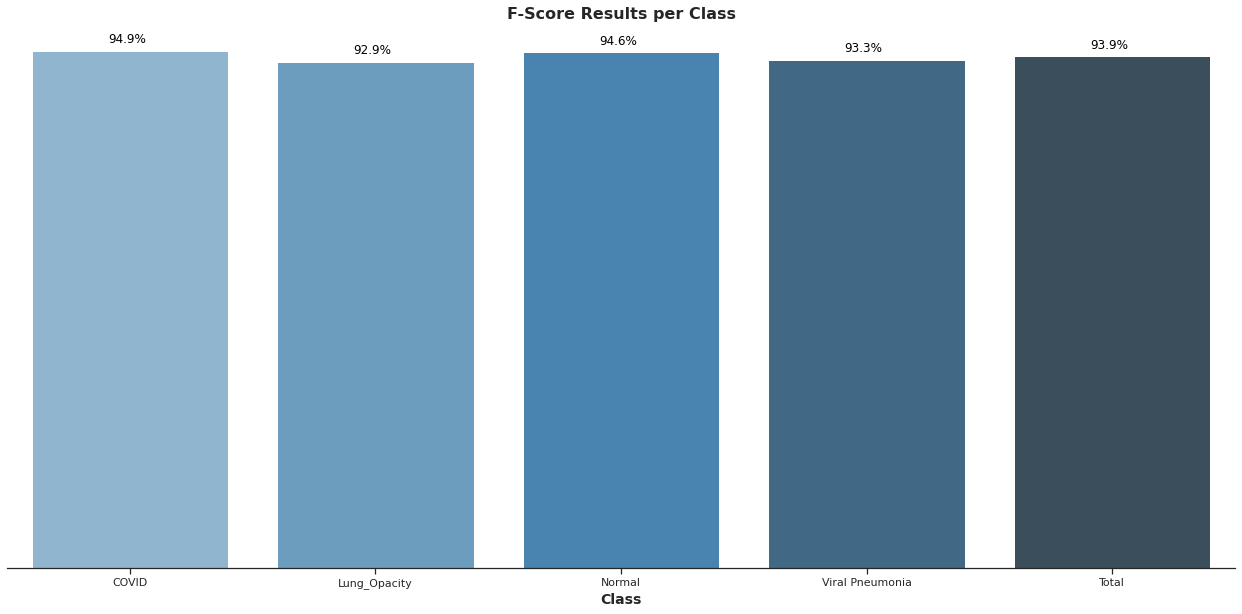

In [10]:
acc = accuracy_score(true, predictions)
results_all = precision_recall_fscore_support(true, predictions, average='macro',zero_division = 1)
results_class = precision_recall_fscore_support(true, predictions, average=None, zero_division = 1)

metric_columns = ['Precision','Recall', 'F-Score','S']
bar = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
bar.columns = metric_columns
bar.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

def met_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
met_plot(bar, 'Precision')
met_plot(bar, 'Recall')
met_plot(bar, 'F-Score')
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100))
print('Precision Result: %.2f%%'%(bar.iloc[4,0]*100))
print('Recall Result: %.2f%%'%(bar.iloc[4,1]*100))
print('F-Score Result: %.2f%%'%(bar.iloc[4,2]*100))
